# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [51]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [52]:
max_iterations = 50
loop_count = 13

In [53]:

dev_1 = qml.device('default.qubit', wires=2)
dev_2 = qml.device('default.qubit', wires=2)
dev_3 = qml.device('default.qubit', wires=2)

## Classifier 1
init_weights_1 = (0.01 * np.random.randn(6*3), 0.0)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    # layer 1
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])

    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])

    # layer 2
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])

    qml.Rot(weights[6], weights[7], weights[8], wires=0)
    qml.Rot(weights[9], weights[10], weights[11], wires=1)
    
    qml.CNOT(wires=[0, 1])

    # layer 3
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])

    qml.Rot(weights[12], weights[13], weights[14], wires=0)
    qml.Rot(weights[15], weights[16], weights[17], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
init_weights_2 = (0.01 * np.random.randn(6*3), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    # layer 1
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    # layer 2
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[6], weights[7], weights[8], wires=0)
    qml.Rot(weights[9], weights[10], weights[11], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    # layer 3
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[12], weights[13], weights[14], wires=0)
    qml.Rot(weights[15], weights[16], weights[17], wires=1)
    
    qml.CNOT(wires=[0, 1])


    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
init_weights_3 = (0.01 * np.random.randn(6*3), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    # layer 1
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    # layer 2
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[6], weights[7], weights[8], wires=0)
    qml.Rot(weights[9], weights[10], weights[11], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    # layer 3
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[12], weights[13], weights[14], wires=0)
    qml.Rot(weights[15], weights[16], weights[17], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


In [54]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

Loop count: 0


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8785398 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8741567 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8704675 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8683776 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8700451 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     6 | Cost: 0.8739079 | Acc train: 0.7600000 | Acc val: 0.6800000 | Acc all: 0.7000000 
Iter:     7 | Cost: 0.8799796 | Acc train: 0.7600000 | Acc val: 0.6800000 | Acc all: 0.7200000 
Iter:     8 | Cost: 0.8848554 | Acc train: 0.7200000 | Acc val: 0.6800000 | Acc all: 0.7200000 
Iter:     9 | Cost: 0.8926418 | Acc train: 0.7200000 | Acc val: 0.6800000 | Acc all: 0.7200000 
Iter:    10 | Cost: 0.8925816 | Acc train: 0.7200000 | Acc val: 0.6800000 | Acc all: 0.7200000 
Iter:    11 | Cost: 0.8858736 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5132522 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5107047 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5067164 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.4984488 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4850525 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.4675480 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.4461202 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4287125 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.4082577 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.3855963 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.3626827 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2233011 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2254700 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2270903 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2281133 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2283590 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2251073 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.2223210 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.2204908 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.2190230 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:    10 | Cost: 1.2187654 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2200607 | Acc trai

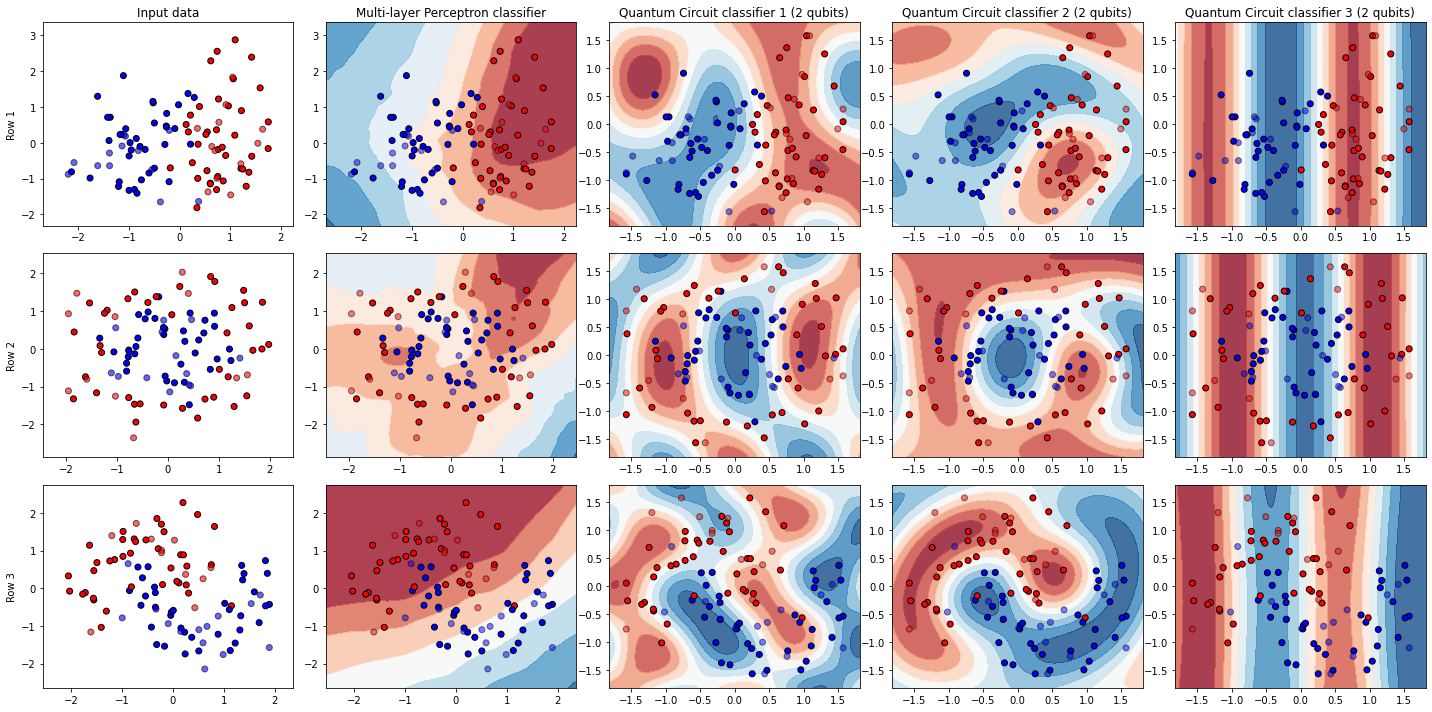

Loop count: 1


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8805066 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8801223 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8795464 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8795101 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8829354 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8790322 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8761264 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8700425 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8655462 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8594995 | Acc train: 0.7066667 | Acc val: 0.6400000 | Acc all: 0.7200000 
Iter:    11 | Cost: 0.8472945 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5124018 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5091986 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5084395 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5051612 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.5002596 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.4936607 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.4869455 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.4803555 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4717407 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.4601542 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.4550921 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2223191 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2212835 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2183377 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2149194 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2131166 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2146043 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2182316 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:     8 | Cost: 1.2208576 | Acc train: 0.5866667 | Acc val: 0.4400000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.2210187 | Acc train: 0.5866667 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2194056 | Acc train: 0.5866667 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2171842 | Acc trai

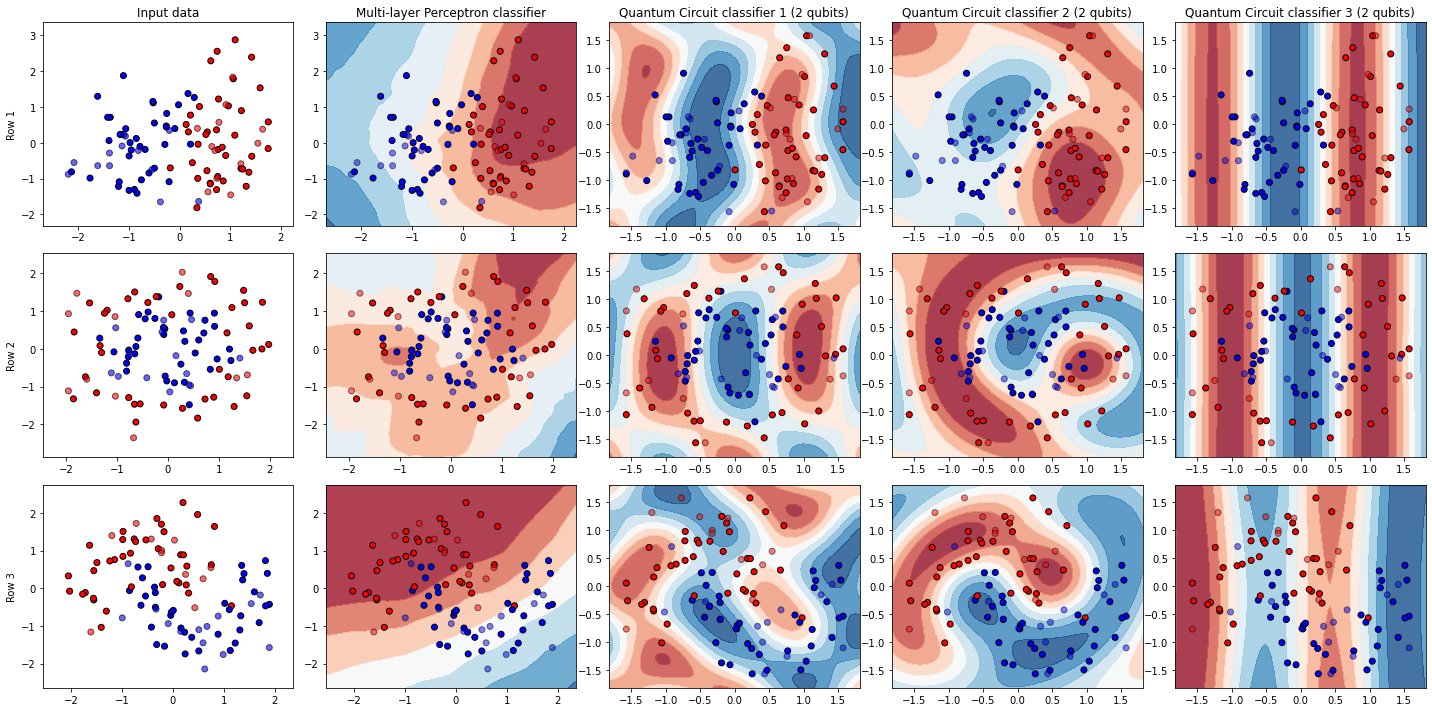

Loop count: 2


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8790395 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8792432 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8777468 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8748292 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     5 | Cost: 0.8730425 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     6 | Cost: 0.8701734 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8665380 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8625468 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     9 | Cost: 0.8604590 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:    10 | Cost: 0.8548070 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8486521 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5138638 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5131322 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5113419 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5128386 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.5126629 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.5045365 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.4939026 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.4846891 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.4764827 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.4758105 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.4712150 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2219562 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2216345 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2212328 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2213916 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2217220 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2226258 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2242281 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2278790 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2309823 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2305910 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2293284 | Acc trai

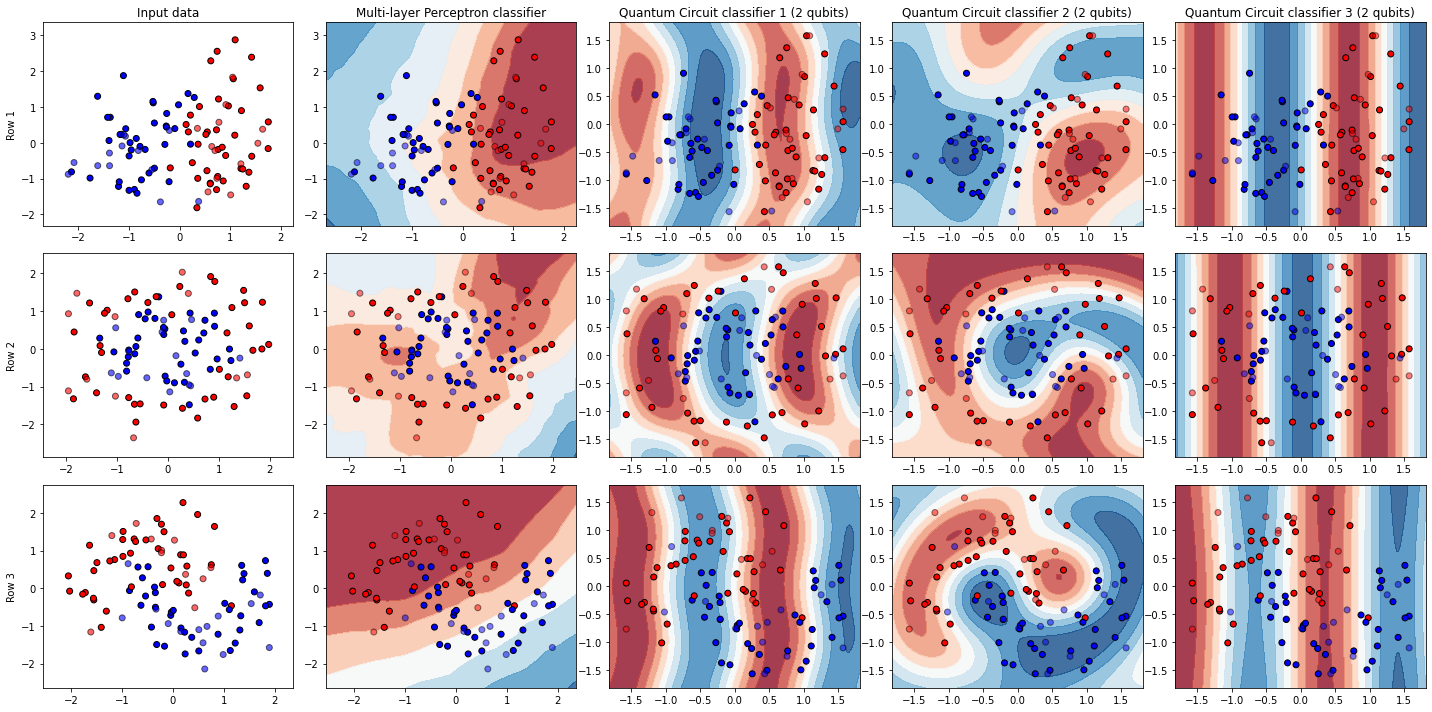

Loop count: 3


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8775140 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8742842 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8688632 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8635767 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8584632 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8512359 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8428511 | Acc train: 0.7200000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8351813 | Acc train: 0.7200000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8281175 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8219714 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8181435 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5109150 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5129059 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5132188 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5108027 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.5057697 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.4981884 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.4891285 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.4762057 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.4657880 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.4530007 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.4357792 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2222999 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2219752 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2212569 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2200858 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2202678 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2209583 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2239246 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2276163 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2291758 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5900000 
Iter:    10 | Cost: 1.2314200 | Acc train: 0.5866667 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2292145 | Acc trai

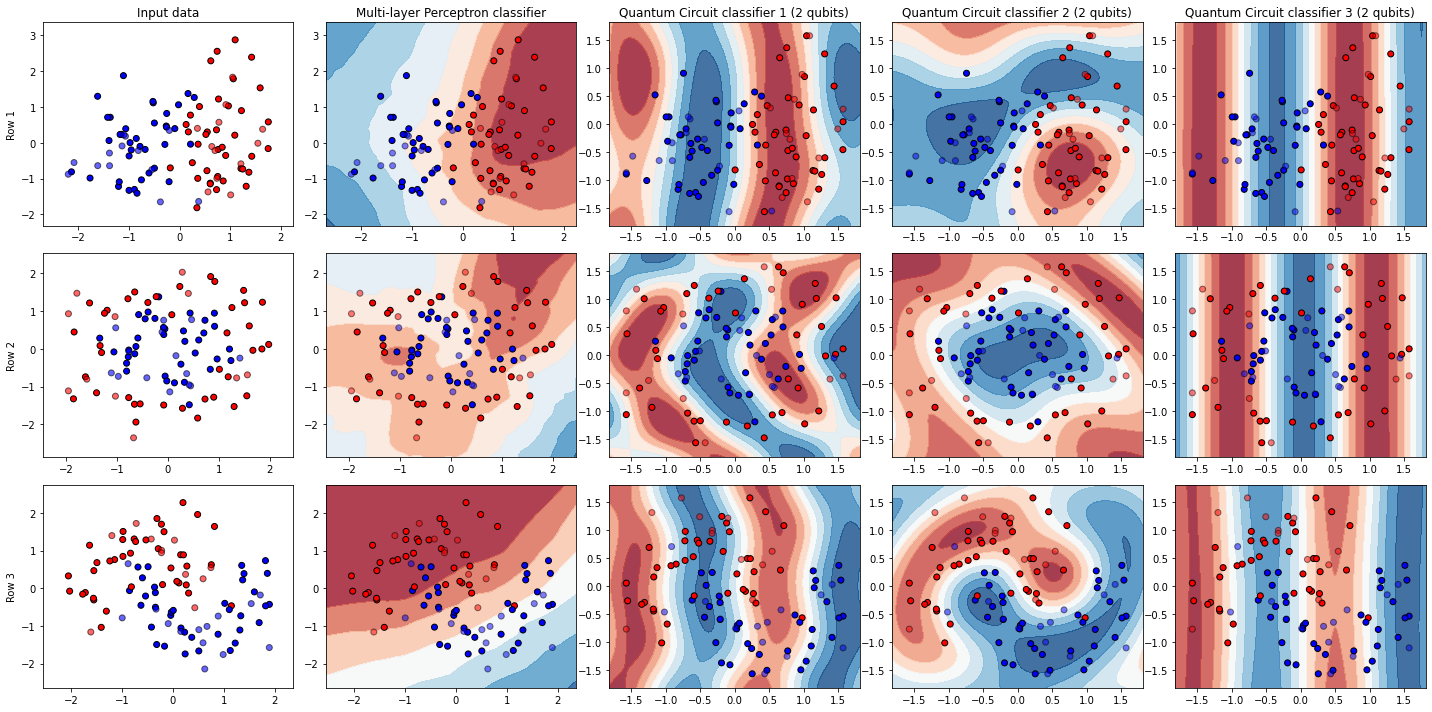

Loop count: 4


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8792418 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8766687 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8724657 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8674532 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8595053 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8528190 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8478278 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8444029 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8407631 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:    10 | Cost: 0.8382222 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8299803 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5177006 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5238227 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5246092 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5306836 | Acc train: 0.4933333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.5354187 | Acc train: 0.4933333 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.5356553 | Acc train: 0.4933333 | Acc val: 0.4800000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.5353673 | Acc train: 0.4933333 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.5348076 | Acc train: 0.4800000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.5262483 | Acc train: 0.4933333 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.5117403 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.4913158 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2215461 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2209533 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2208465 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2207812 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2209449 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2212042 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2206368 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2207808 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2223158 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.2244866 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2243495 | Acc trai

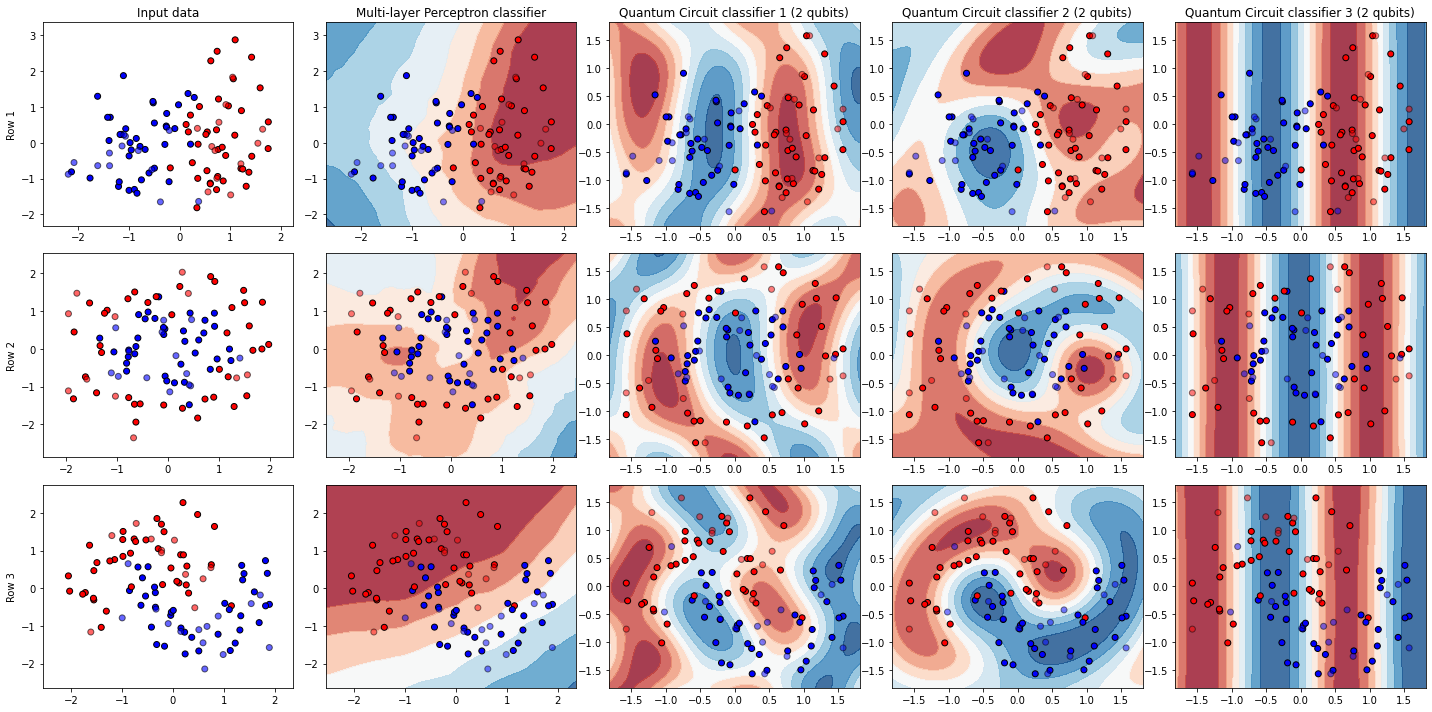

Loop count: 5


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8746435 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8707897 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8699265 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8696676 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     5 | Cost: 0.8704270 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     6 | Cost: 0.8706795 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     7 | Cost: 0.8709634 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     8 | Cost: 0.8668758 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     9 | Cost: 0.8582534 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:    10 | Cost: 0.8527551 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:    11 | Cost: 0.8501393 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5091559 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5052523 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5044867 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4994855 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4924657 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.4883183 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5000000 
Iter:     7 | Cost: 1.4770755 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.4683686 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.4603895 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.4527884 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.4423638 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2245153 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2265177 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2253645 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2251458 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2248402 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2229399 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.2208770 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.2199242 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.2207944 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2227903 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.2249709 | Acc trai

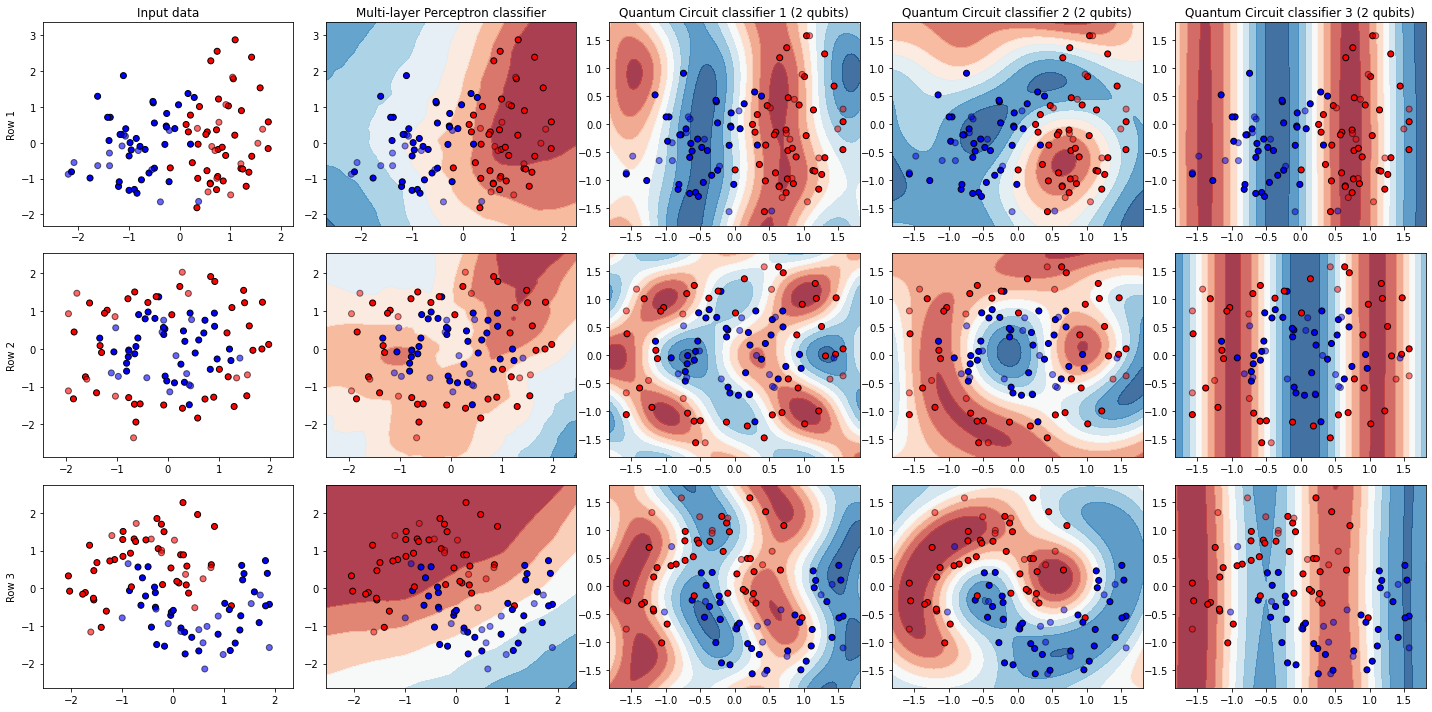

Loop count: 6


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8781793 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8745833 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8712472 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8664775 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     5 | Cost: 0.8586273 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8499718 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8427051 | Acc train: 0.7200000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8347839 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8254961 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8175670 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8079469 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5179238 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5213656 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5180419 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5181714 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.5150381 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.5057595 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.4951835 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.4896159 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.4790283 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.4688587 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.4524836 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2236533 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2257419 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2312715 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2338147 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2370852 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2397629 | Acc train: 0.6000000 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2404948 | Acc train: 0.6000000 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2353412 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2305571 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:    10 | Cost: 1.2295657 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.2295433 | Acc trai

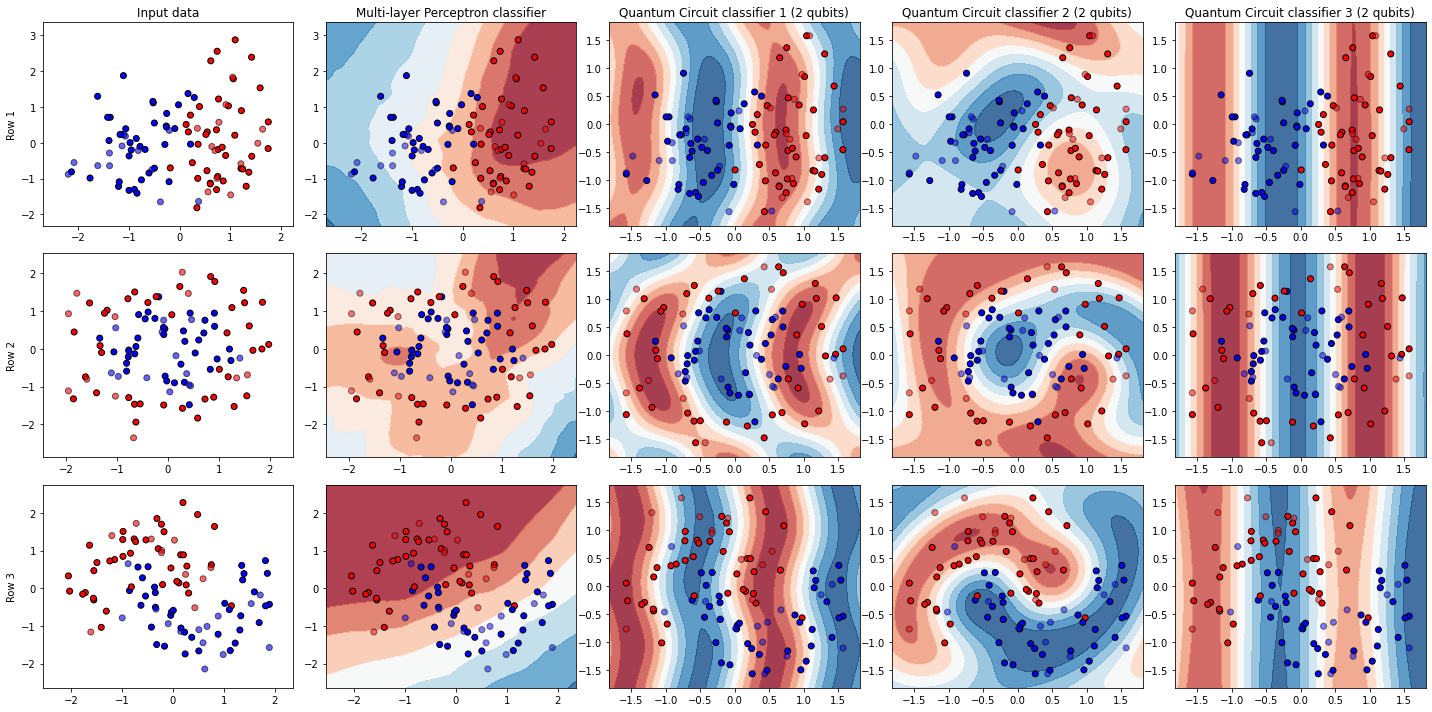

Loop count: 7


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8816126 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8836569 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8834138 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     4 | Cost: 0.8819564 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7000000 
Iter:     5 | Cost: 0.8803741 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7000000 
Iter:     6 | Cost: 0.8777327 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.6900000 
Iter:     7 | Cost: 0.8752112 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.6900000 
Iter:     8 | Cost: 0.8740042 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.6900000 
Iter:     9 | Cost: 0.8732554 | Acc train: 0.6933333 | Acc val: 0.6400000 | Acc all: 0.6900000 
Iter:    10 | Cost: 0.8695793 | Acc train: 0.7066667 | Acc val: 0.6400000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.8657793 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5166792 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5237405 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5331978 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5429230 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4900000 
Iter:     5 | Cost: 1.5492141 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4700000 
Iter:     6 | Cost: 1.5500586 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4600000 
Iter:     7 | Cost: 1.5491268 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4800000 
Iter:     8 | Cost: 1.5460923 | Acc train: 0.4933333 | Acc val: 0.4800000 | Acc all: 0.4800000 
Iter:     9 | Cost: 1.5394814 | Acc train: 0.4933333 | Acc val: 0.4800000 | Acc all: 0.4800000 
Iter:    10 | Cost: 1.5321170 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.4900000 
Iter:    11 | Cost: 1.5283001 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2218626 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2207024 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2204367 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2203156 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2200609 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2201115 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2196378 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.2189153 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2185109 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2191270 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.2200891 | Acc trai

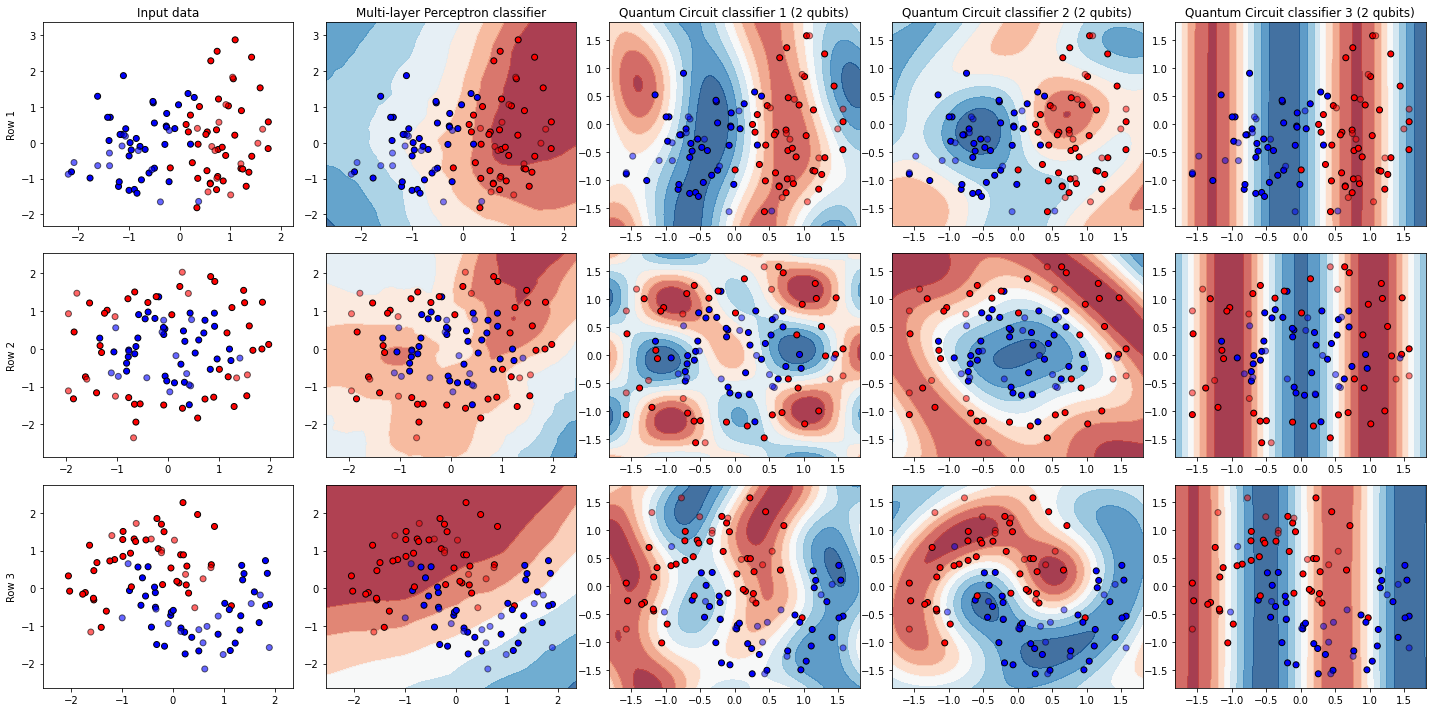

Loop count: 8


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8760090 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8727211 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8717652 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     4 | Cost: 0.8695137 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     5 | Cost: 0.8671613 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8659143 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8635780 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8634156 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8626530 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7200000 
Iter:    10 | Cost: 0.8664834 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:    11 | Cost: 0.8708848 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5135542 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5088909 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5022911 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.4942073 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.4800444 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.4543507 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4305868 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4017872 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.3647076 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.3294878 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.2907488 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2209789 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2202766 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2204623 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2208734 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2213390 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2228124 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2239626 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2257039 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2265349 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2283463 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.2304588 | Acc trai

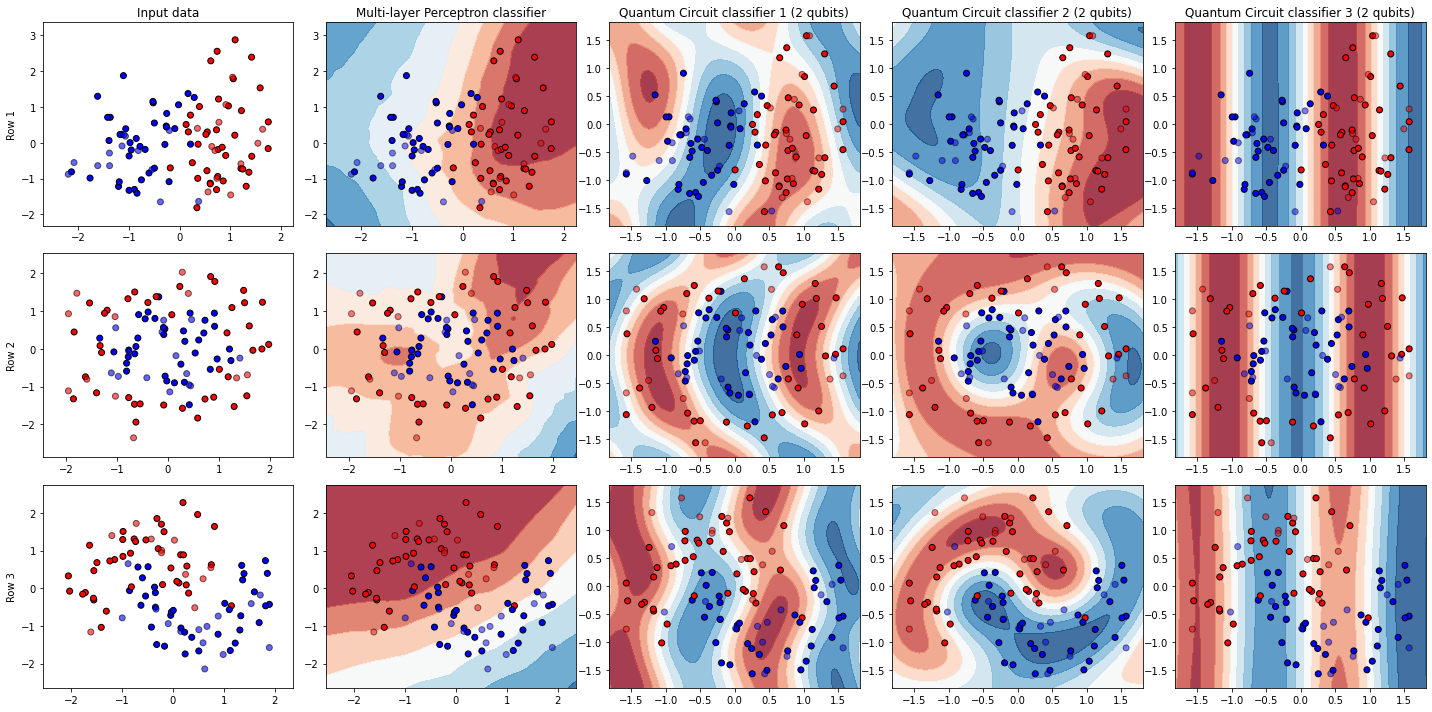

Loop count: 9


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8792761 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8798999 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8774584 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8722327 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8704608 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     6 | Cost: 0.8675676 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     7 | Cost: 0.8612980 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8550458 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8487742 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8433619 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8368198 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5208168 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5247022 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5275536 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5296952 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.5296636 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4900000 
Iter:     6 | Cost: 1.5253941 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4900000 
Iter:     7 | Cost: 1.5208439 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4900000 
Iter:     8 | Cost: 1.5165290 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4900000 
Iter:     9 | Cost: 1.5112272 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4900000 
Iter:    10 | Cost: 1.5021714 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.4900000 
Iter:    11 | Cost: 1.4913290 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2233652 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2230076 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2222316 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2251213 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2263710 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2246402 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.2198423 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.2160536 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.2133903 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2108476 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2078842 | Acc trai

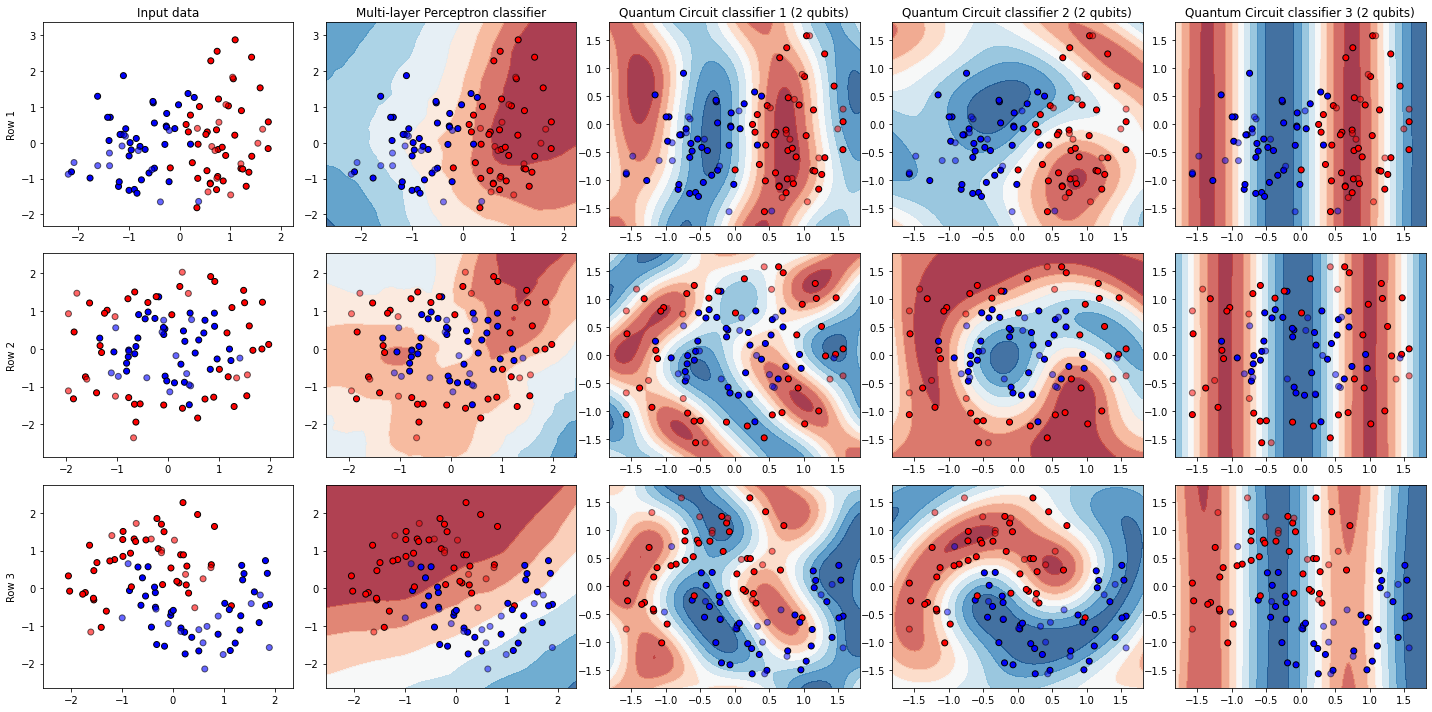

Loop count: 10


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8781185 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8764681 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8742965 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8725273 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     5 | Cost: 0.8707939 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     6 | Cost: 0.8668934 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8631171 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8596649 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8539188 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8507877 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:    11 | Cost: 0.8444591 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5151049 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5114992 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5087006 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5039520 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.4926429 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.4799448 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.4660211 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.4504208 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4325289 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.4122495 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.3856728 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2216495 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2207614 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2203726 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2221277 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2257077 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:     6 | Cost: 1.2241927 | Acc train: 0.6400000 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:     7 | Cost: 1.2242961 | Acc train: 0.6400000 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:     8 | Cost: 1.2231060 | Acc train: 0.6400000 | Acc val: 0.5600000 | Acc all: 0.6100000 
Iter:     9 | Cost: 1.2254489 | Acc train: 0.6400000 | Acc val: 0.5600000 | Acc all: 0.6100000 
Iter:    10 | Cost: 1.2299514 | Acc train: 0.6533333 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:    11 | Cost: 1.2343380 | Acc trai

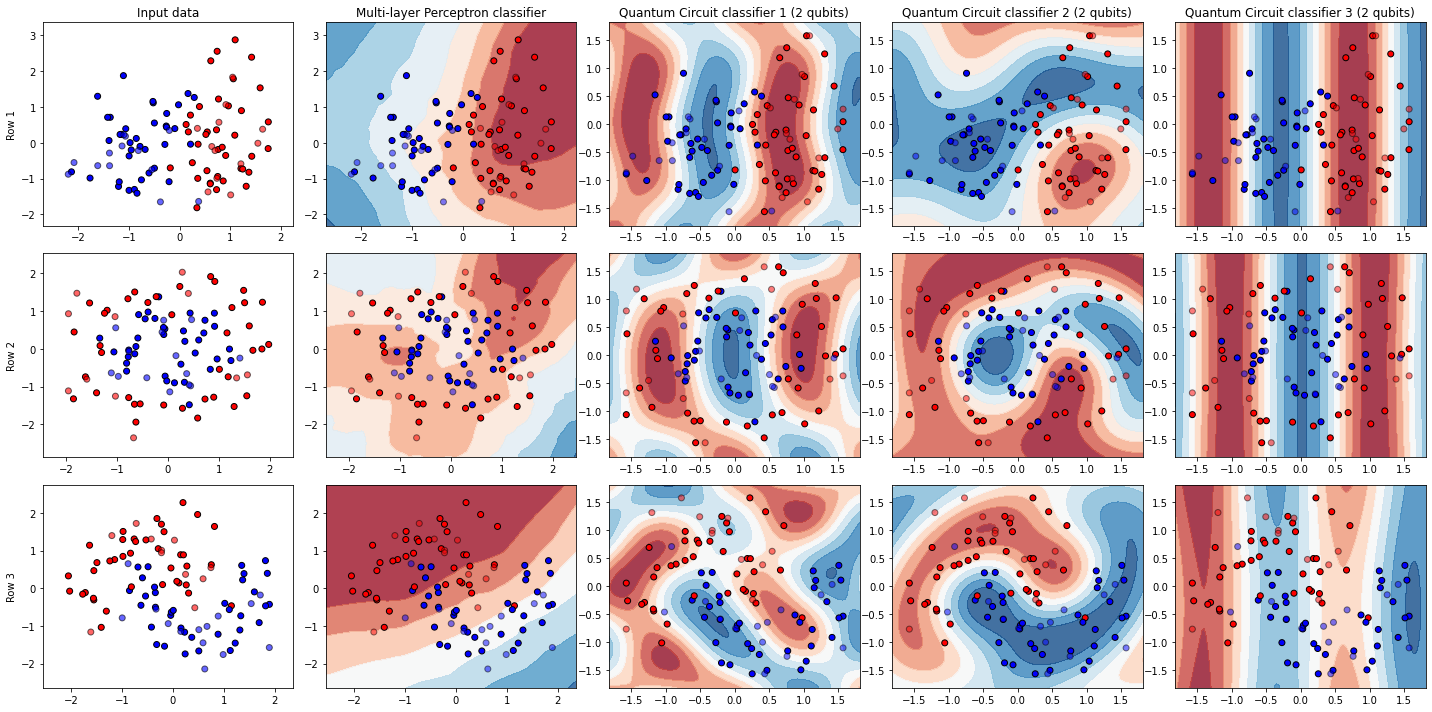

Loop count: 11


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8753976 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8680580 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8598800 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8531257 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8452841 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8374934 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     7 | Cost: 0.8288209 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8178146 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8052637 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.7936726 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.7840578 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5144744 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5119786 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     3 | Cost: 1.5084057 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.5064544 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.5051911 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.5024316 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.5018000 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.4971056 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4862009 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.4725677 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.4585380 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2220837 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2219257 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2201802 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2189896 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2179130 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2176980 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2173262 | Acc train: 0.5866667 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2173997 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2179343 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2169445 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.2165706 | Acc trai

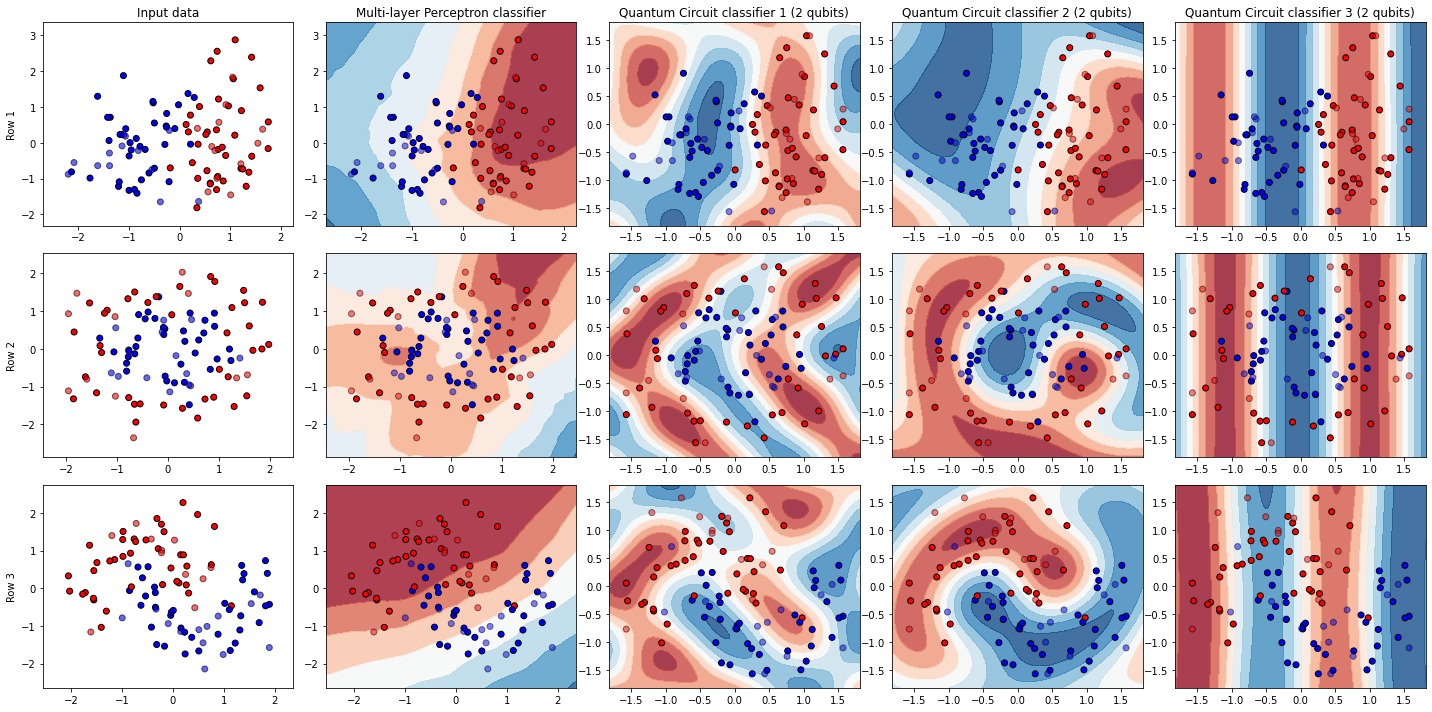

Loop count: 12


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8801914 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     2 | Cost: 0.8807937 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8812919 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8812619 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8823043 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     6 | Cost: 0.8867270 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7000000 
Iter:     7 | Cost: 0.8883011 | Acc train: 0.7333333 | Acc val: 0.6800000 | Acc all: 0.7000000 
Iter:     8 | Cost: 0.8915959 | Acc train: 0.7200000 | Acc val: 0.6800000 | Acc all: 0.7000000 
Iter:     9 | Cost: 0.8925404 | Acc train: 0.7200000 | Acc val: 0.6800000 | Acc all: 0.7000000 
Iter:    10 | Cost: 0.8943901 | Acc train: 0.7200000 | Acc val: 0.6800000 | Acc all: 0.7000000 
Iter:    11 | Cost: 0.8950155 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5091397 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5028642 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.4987162 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.4921757 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4860133 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.4807065 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4797421 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.4794181 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4731716 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.4671804 | Acc train: 0.5466667 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.4546904 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2232286 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2239682 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2228271 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2221594 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2218072 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2218000 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2226385 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2225396 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2224925 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2224389 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2220125 | Acc trai

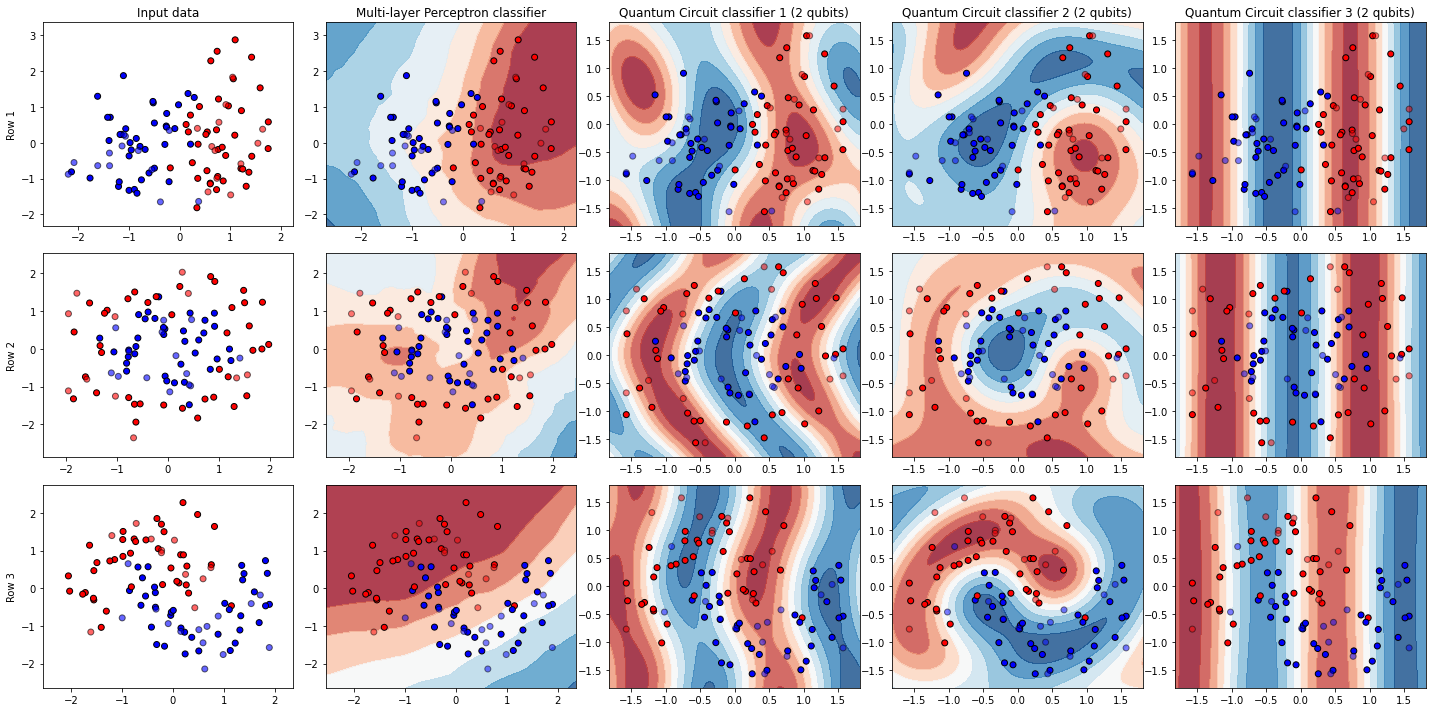

scores: [[[0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]
  [0.76 0.44 0.88]]

 [[0.88 0.64 0.52]
  [0.68 0.64 0.56]
  [0.76 0.52 0.48]
  [0.8  0.64 0.48]
  [0.72 0.6  0.48]
  [0.8  0.68 0.48]
  [0.64 0.52 0.48]
  [0.76 0.4  0.52]
  [0.8  0.48 0.52]
  [0.72 0.64 0.52]
  [0.68 0.6  0.56]
  [0.8  0.56 0.52]
  [0.88 0.48 0.48]]

 [[0.76 0.68 0.88]
  [0.88 0.56 0.88]
  [0.84 0.68 0.88]
  [0.76 0.92 0.92]
  [0.84 0.68 0.88]
  [0.72 0.76 0.88]
  [0.88 0.72 0.84]
  [0.8  0.96 0.88]
  [0.92 0.72 0.88]
  [0.76 0.76 0.8 ]
  [0.76 0.68 0.92]
  [0.92 0.68 0.92]
  [0.88 0.72 0.88]]

 [[0.64 0.6  0.48]
  [0.68 0.56 0.48]
  [0.72 0.56 0.52]
  [0.68 0.6  0.48]
  [0.72 0.48 0.48]
  [0.72 0.52 0.44]
  [0.68 0.56 0.44]
  [0.68 0.6  0.44]
  [0.72 0.56 0.52]
  [0.68 0.48 0.44]
  [0.68 0.52 0.4 ]
  [0.68 0.56 0.52]
  [0.68 0.64 0.52

In [55]:
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    "Quantum Circuit classifier 1 (2 qubits)",
    "Quantum Circuit classifier 2 (2 qubits)",
    "Quantum Circuit classifier 3 (2 qubits)",
]

classifiers = [
  MLPClassifier(random_state=1, hidden_layer_sizes=(100,100,100), max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  print("Loop count:", l_count)
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')
  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds

      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )

      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=pi/2
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      # ax.set_xticks(())
      # ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
          
          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )
            
            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())

            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #     xx.max() - 0.3,
            #     yy.min() + 0.3,
            #     ("Score: %.2f" % score).lstrip("0"),
            #     size=15,
            #     horizontalalignment="right",
            # )
            
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)


In [56]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (2 qubits)
 0: ──H──RY(1.81)──╭C──Rot(0.0609, 0.258, 0.0443)──╭C──RY(1.81)──╭C──Rot(0.000286, 0.397, 0.0467)──╭C──RY(1.81)──╭C──Rot(0.00357, -0.0404, -0.000227)──╭C──┤ ⟨Z⟩ 
 1: ──H──RY(1.81)──╰X──Rot(0.158, -0.179, 0.17)────╰X──RY(1.81)──╰X──Rot(0.0741, -0.126, 0.0429)───╰X──RY(1.81)──╰X──Rot(0.000757, 0.017, 0.000706)────╰X──┤     

Quantum Circuit classifier 2 (2 qubits)
 0: ──H──RY(1.81)──RX(1.81)──╭C──Rot(-0.282, -0.033, -0.284)──────╭C──RY(1.81)──RX(1.81)──╭C──Rot(-0.296, 0.163, -0.291)─────╭C──RY(1.81)──RX(1.81)──╭C──Rot(-0.0443, -0.262, -0.00212)──╭C──┤ ⟨Z⟩ 
 1: ──H──────────────────────╰X──Rot(-0.00637, 0.0172, -0.00501)──╰X──────────────────────╰X──Rot(-0.0055, 0.00496, 0.0134)──╰X──────────────────────╰X──Rot(0.00245, 0.00811, -0.0107)──╰X──┤     

Quantum Circuit classifier 3 (2 qubits)
 0: ──H──RY(1.81)──╭C──Rot(0.027, 0.0433, 0.0576)───╭C──RY(1.81)──╭C──Rot(-0.00826, 0.0531, 0.0278)──╭C──RY(1.81)──╭C──Rot(0.0161, 0.0476, 0.00476)─────╭C──┤ ⟨Z⟩ 

C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
